Mounted at /content/drive
Loaded 194801 rows.

ANALYSIS: Composition of Negative(0) vs Positive(1) per Score Range
       Count of Label 0 (Neg)  Count of Label 1 (Pos)  Total
Score                                                       
0                        1781                       3   1784
1                        1800                       1   1801
2                       13069                      19  13088
3                       12748                      19  12767
4                       25773                     168  25941
5                       28476                    1262  29738
6                       13045                   26284  39329
7                         243                   28535  28778
8                          86                   29438  29524
9                           2                    4821   4823
10                         13                    7215   7228
------------------------------------------------------------
Generating Interval Analysis Gr

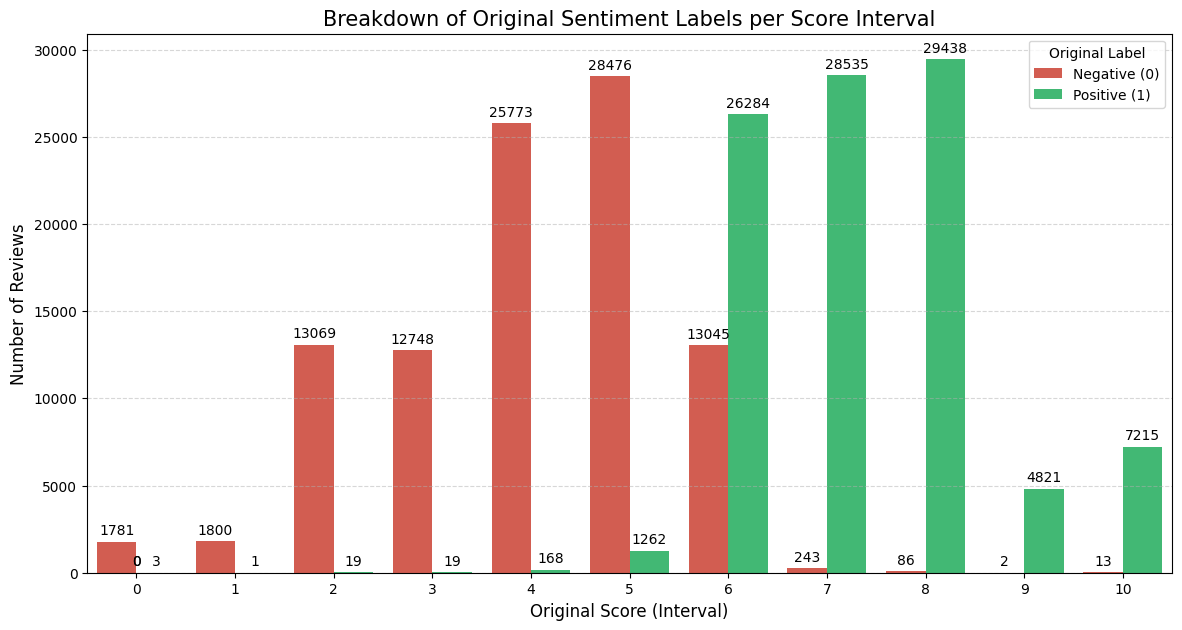

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

# --- 1. Setup ---
np.random.seed(42)
try:
    drive.mount('/content/drive')
except Exception:
    pass

# --- 2. Load Data ---
ORIGINAL_FILE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/[Non English reviews deleted] All_Language_Data.csv'

try:
    df = pd.read_csv(ORIGINAL_FILE_PATH)
    df = df.dropna(subset=['originalScore', 'sentiment_label'])
    print(f"Loaded {len(df)} rows.")
except Exception as e:
    print(f"Error: {e}")
    raise

# ======================================================
# REQUIREMENT: Interval Analysis Table & Graph
# ======================================================
print("\n" + "="*60)
print("ANALYSIS: Composition of Negative(0) vs Positive(1) per Score Range")
print("="*60)

# 1. Create the score interval column (integer floors: 3.5 -> 3)
df['score_interval'] = np.floor(df['originalScore']).astype(int)

# 2. Create and Print the Table
interval_table = pd.crosstab(
    df['score_interval'],
    df['sentiment_label']
)
interval_table.columns = ['Count of Label 0 (Neg)', 'Count of Label 1 (Pos)']
interval_table.index.name = 'Score'
interval_table['Total'] = interval_table['Count of Label 0 (Neg)'] + interval_table['Count of Label 1 (Pos)']

print(interval_table)
print("-" * 60)

# 3. Generate the Graph
print("Generating Interval Analysis Graph...")
plt.figure(figsize=(14, 7))

# Create a grouped bar chart
# hue='sentiment_label' splits the bars into 0 (Neg) and 1 (Pos) side-by-side
ax = sns.countplot(
    data=df,
    x='score_interval',
    hue='sentiment_label',
    palette={0: '#e74c3c', 1: '#2ecc71'} # Red for Neg, Green for Pos
)

plt.title('Breakdown of Original Sentiment Labels per Score Interval', fontsize=15)
plt.xlabel('Original Score (Interval)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.legend(title='Original Label', labels=['Negative (0)', 'Positive (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add counts on top of EACH bar
for p in ax.patches:
    height = p.get_height()
    # Handle NaN (empty bars) to avoid errors
    if not pd.isna(height):
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=10, color='black', xytext=(0, 3),
                    textcoords='offset points')

plt.show()
print("="*60)

In [2]:
# ======================================================
# STEP 1: Create the 3 Classes (0-4, 4-7, 7-10)
# ======================================================
# Logic:
#   Negative: 0 to 3.999... (4 is excluded)
#   Neutral:  4 to 6.999... (7 is excluded)
#   Positive: 7 to 10
bin_edges = [0, 4, 7, 10.1]
class_names_3 = ["Negative", "Neutral", "Positive"]

df['sentiment_3class'] = pd.cut(
    df['originalScore'],
    bins=bin_edges,
    labels=class_names_3,
    right=False,
    include_lowest=True
)

# ======================================================
# STEP 2: Specific Filtering & Sampling
# ======================================================
print("\nProcessing Sampling Requests...")

# --- A. NEGATIVE CLASS (Target: All valid data ~29k) ---
# Requirement: Must include ONLY sentiment_label == 0
df_neg_final = df[
    (df['sentiment_3class'] == 'Negative') &
    (df['sentiment_label'] == 0)
].copy()
# No downsampling (take all)
print(f"   > Negative Class: Kept all {len(df_neg_final)} valid samples.")


# --- B. POSITIVE CLASS (Target: 40,000) ---
# Requirement: Must include ONLY sentiment_label == 1
df_pos_pool = df[
    (df['sentiment_3class'] == 'Positive') &
    (df['sentiment_label'] == 1)
].copy()

# Sample 40,000
if len(df_pos_pool) >= 40000:
    df_pos_final = df_pos_pool.sample(n=40000, random_state=42)
    print(f"   > Positive Class: Downsampled from {len(df_pos_pool)} to 40,000.")
else:
    df_pos_final = df_pos_pool
    print(f"   > Positive Class: Warning! Only {len(df_pos_pool)} available (less than 40k). Kept all.")


# --- C. NEUTRAL CLASS (Target: 40,000 -> 20k Neg + 20k Pos) ---
# Requirement: Mix of label 0 and label 1
neu_pool_0 = df[(df['sentiment_3class'] == 'Neutral') & (df['sentiment_label'] == 0)]
neu_pool_1 = df[(df['sentiment_3class'] == 'Neutral') & (df['sentiment_label'] == 1)]

# Sample 20k from each side
# We use min() just in case one side has less than 20k (unlikely but safe)
n_target_half = 20000

# Sample 0s
n_take_0 = min(len(neu_pool_0), n_target_half)
neu_sample_0 = neu_pool_0.sample(n=n_take_0, random_state=42)

# Sample 1s
n_take_1 = min(len(neu_pool_1), n_target_half)
neu_sample_1 = neu_pool_1.sample(n=n_take_1, random_state=42)

df_neu_final = pd.concat([neu_sample_0, neu_sample_1])
print(f"   > Neutral Class: Created mixed pool of {len(df_neu_final)} samples.")
print(f"       ({len(neu_sample_0)} from label 0 + {len(neu_sample_1)} from label 1)")


# ======================================================
# STEP 3: Combine & Clean
# ======================================================
# Concat everything
df_final = pd.concat([df_neg_final, df_pos_final, df_neu_final])

# Shuffle rows
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

# Create the Integer Target Label (0, 1, 2)
le = LabelEncoder()
df_final['3 class label'] = le.fit_transform(df_final['sentiment_3class'])

print("\n" + "="*60)
print(f"FINAL DATASET TOTAL: {len(df_final)} rows")
print("="*60)
print(df_final['sentiment_3class'].value_counts())


Processing Sampling Requests...
   > Negative Class: Kept all 29398 valid samples.
   > Positive Class: Downsampled from 70009 to 40,000.
   > Neutral Class: Created mixed pool of 40000 samples.
       (20000 from label 0 + 20000 from label 1)

FINAL DATASET TOTAL: 109398 rows
sentiment_3class
Neutral     40000
Positive    40000
Negative    29398
Name: count, dtype: int64


/tmp/ipython-input-3179749827.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_final, x='sentiment_3class', palette='viridis')


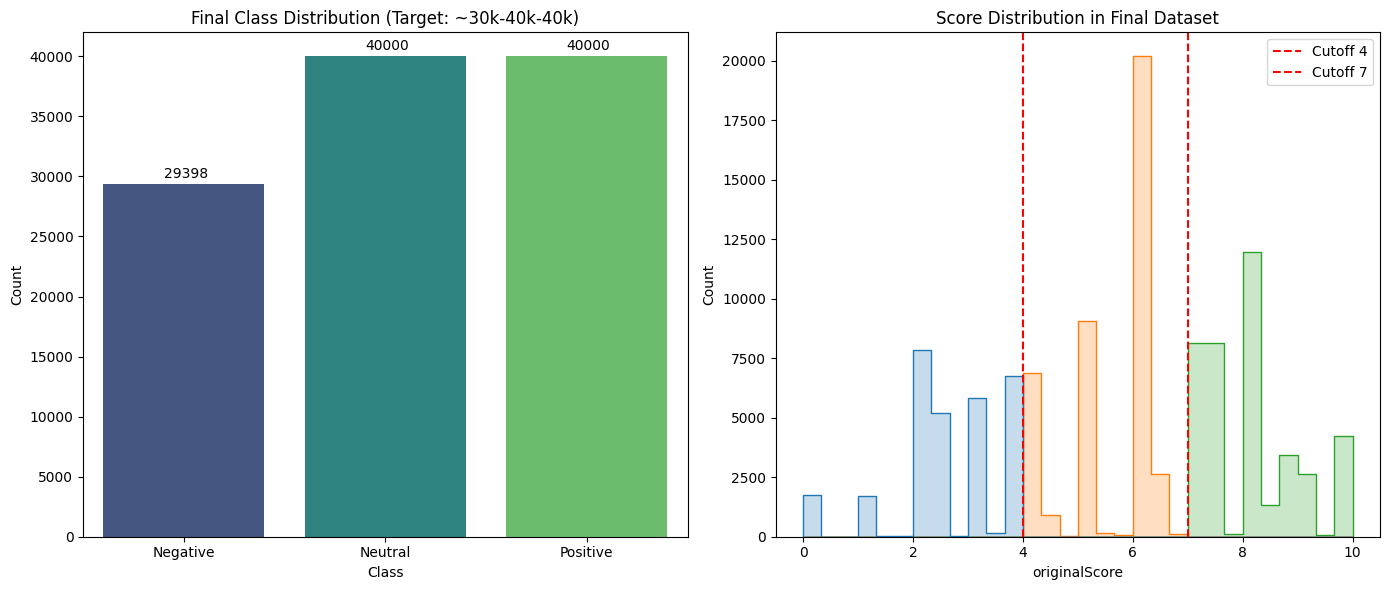


✅ SUCCESS! Saved to: /content/drive/MyDrive/THESIS 47/Saved Datasets/110k_data_0_4_7_10_range.csv
Final Shape: (109398, 10)
First 5 rows of final file:
   sentiment_label  3 class label
0                0              1
1                1              2
2                0              1
3                1              2
4                0              0


In [3]:
# ======================================================
# STEP 4: Visualization (Verification)
# ======================================================
plt.figure(figsize=(14, 6))

# GRAPH A: Final Class Counts
plt.subplot(1, 2, 1)
ax = sns.countplot(data=df_final, x='sentiment_3class', palette='viridis')
plt.title('Final Class Distribution (Target: ~30k-40k-40k)')
plt.xlabel('Class')
plt.ylabel('Count')
for p in ax.patches:
   ax.annotate(f'{int(p.get_height())}', (p.get_x()+0.3, p.get_height()+500))

# GRAPH B: Score Distribution within the Classes
plt.subplot(1, 2, 2)
sns.histplot(data=df_final, x='originalScore', hue='sentiment_3class', bins=30, element="step")
plt.title('Score Distribution in Final Dataset')
plt.axvline(x=4, color='r', linestyle='--', label='Cutoff 4')
plt.axvline(x=7, color='r', linestyle='--', label='Cutoff 7')
plt.legend()

plt.tight_layout()
plt.show()

# ======================================================
# STEP 5: Saving
# ======================================================
# Columns to keep: Metadata + New Labels
# Remove intermediate calculation columns
cols_to_drop = ['originalScore', 'sentiment_3class', 'score_interval', 'label']
# Note: 'label' was from previous encodings if present, we ensure we keep '3 class label'

cols_keep = [c for c in df_final.columns if c not in cols_to_drop]

# Reorder to put labels at the end
final_cols = [c for c in cols_keep if c not in ['sentiment_label', '3 class label']] + ['sentiment_label', '3 class label']

df_save = df_final[final_cols]

SAVE_DIR = '/content/drive/MyDrive/THESIS 47/Saved Datasets'
FILE_NAME = '110k_data_0_4_7_10_range.csv'
SAVE_PATH = os.path.join(SAVE_DIR, FILE_NAME)

try:
    df_save.to_csv(SAVE_PATH, index=False)
    print(f"\n✅ SUCCESS! Saved to: {SAVE_PATH}")
    print(f"Final Shape: {df_save.shape}")
    print("First 5 rows of final file:")
    print(df_save[['sentiment_label', '3 class label']].head())
except Exception as e:
    print(f"Error saving file: {e}")

In [4]:
# ======================================================
# STEP 6: FINAL LOGIC RE-CHECK
# ======================================================
print("\n" + "="*60)
print("FINAL INTEGRITY CHECK: Makeup of Each New Bin")
print("="*60)

# 1. Create the Cross-Tabulation
# We look at the Final 3 Classes vs. The Original Binary Labels
verification_table = pd.crosstab(
    df_final['sentiment_3class'],
    df_final['sentiment_label']
)

# Rename for crystal clear output
verification_table.columns = ['Original Label 0 (Neg)', 'Original Label 1 (Pos)']
verification_table.index.name = 'New 3-Class Label'

print(verification_table)
print("-" * 60)

# 2. Automated Pass/Fail Report
print("Automated Diagnostic Report:")

# Check Negative Bin (Should have ZERO original positives)
neg_bin_errors = verification_table.loc['Negative', 'Original Label 1 (Pos)']
if neg_bin_errors == 0:
    print("✅ Negative Bin: PERFECT. (Contains 0 Positive reviews)")
else:
    print(f"❌ Negative Bin: WARNING. (Contains {neg_bin_errors} Positive reviews)")

# Check Positive Bin (Should have ZERO original negatives)
pos_bin_errors = verification_table.loc['Positive', 'Original Label 0 (Neg)']
if pos_bin_errors == 0:
    print("✅ Positive Bin: PERFECT. (Contains 0 Negative reviews)")
else:
    print(f"❌ Positive Bin: WARNING. (Contains {pos_bin_errors} Negative reviews)")

# Check Neutral Bin (Should have a mix)
neu_0 = verification_table.loc['Neutral', 'Original Label 0 (Neg)']
neu_1 = verification_table.loc['Neutral', 'Original Label 1 (Pos)']
print(f"ℹ️ Neutral Bin : Mixed. ({neu_0} Negatives + {neu_1} Positives)")

print("="*60)


FINAL INTEGRITY CHECK: Makeup of Each New Bin
                   Original Label 0 (Neg)  Original Label 1 (Pos)
New 3-Class Label                                                
Negative                            29398                       0
Neutral                             20000                   20000
Positive                                0                   40000
------------------------------------------------------------
Automated Diagnostic Report:
✅ Negative Bin: PERFECT. (Contains 0 Positive reviews)
✅ Positive Bin: PERFECT. (Contains 0 Negative reviews)
ℹ️ Neutral Bin : Mixed. (20000 Negatives + 20000 Positives)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading processed dataset from: /content/drive/MyDrive/THESIS 47/Saved Datasets/110k_data_0_4_7_10_range.csv...
✅ Loaded successfully! Total rows: 109398

COMPOSITION TABLE: New Classes vs. Original Labels
Original Name  Original Neg (0)  Original Pos (1)
Class Name                                       
0 - Negative              29398                 0
1 - Neutral               20000             20000
2 - Positive                  0             40000
------------------------------------------------------------
Generating Composition Graph...


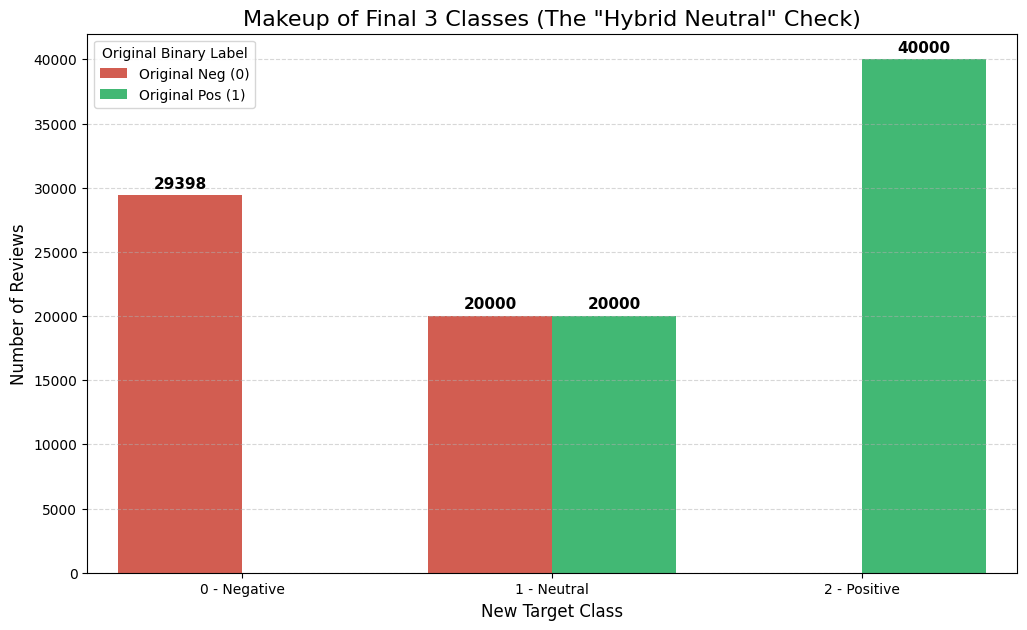

Analysis Complete.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive

# --- 1. Mount Drive & Setup ---
try:
    drive.mount('/content/drive')
except Exception:
    pass # Assuming already mounted

# --- 2. Load the SAVED 110k Dataset ---
# Make sure this matches the exact name of the file we just saved
FILE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/110k_data_0_4_7_10_range.csv'

print(f"Loading processed dataset from: {FILE_PATH}...")
try:
    df_saved = pd.read_csv(FILE_PATH)
    print(f"✅ Loaded successfully! Total rows: {len(df_saved)}")
except FileNotFoundError:
    raise SystemExit("Error: File not found. Make sure you ran the previous 'Saving' code block first.")

# ======================================================
# ANALYTIC LOGIC: New Class vs. Original Label
# ======================================================

# For better graphing, let's map the numbers back to names temporarily
# We know: 0=Negative, 1=Neutral, 2=Positive (based on our previous logic)
label_map = {0: '0 - Negative', 1: '1 - Neutral', 2: '2 - Positive'}
df_saved['Class Name'] = df_saved['3 class label'].map(label_map)

original_map = {0: 'Original Neg (0)', 1: 'Original Pos (1)'}
df_saved['Original Name'] = df_saved['sentiment_label'].map(original_map)

# Create the Cross-Tabulation Table
print("\n" + "="*60)
print("COMPOSITION TABLE: New Classes vs. Original Labels")
print("="*60)
composition_table = pd.crosstab(
    df_saved['Class Name'],
    df_saved['Original Name']
)
print(composition_table)
print("-" * 60)

# ======================================================
# VISUALIZATION
# ======================================================
print("Generating Composition Graph...")
plt.figure(figsize=(12, 7))

# Create the Grouped Bar Chart
ax = sns.countplot(
    data=df_saved,
    x='Class Name',
    hue='Original Name',
    order=['0 - Negative', '1 - Neutral', '2 - Positive'],
    palette={'Original Neg (0)': '#e74c3c', 'Original Pos (1)': '#2ecc71'} # Red vs Green
)

plt.title('Makeup of Final 3 Classes (The "Hybrid Neutral" Check)', fontsize=16)
plt.xlabel('New Target Class', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.legend(title='Original Binary Label')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add counts on top of EACH bar (The "Analysis Like This" part)
for p in ax.patches:
    height = p.get_height()
    # Handle cases where a bar might be 0 height
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=11, fontweight='bold', color='black',
                    xytext=(0, 3), textcoords='offset points')

plt.show()

print("Analysis Complete.")


PART 2: CLEANING & SAVING FULL DATASET (0-4-7-10 Rule)
Applying Strict Purity Filters...
   > Removed 42 contaminated rows from Negative Class.
   > Removed 344 contaminated rows from Positive Class.

✅ SUCCESS! Saved 194415 rows to:
/content/drive/MyDrive/THESIS 47/Saved Datasets/Original_Rule_0_4_7_10_194k.csv

FINAL SANITY CHECK REPORT (0-4-7-10 Rule)
1. Class Composition (Check for Purity):
              Orig Neg (0)  Orig Pos (1)
Negative (0)         29398             0
Neutral (1)          67294         27714
Positive (2)             0         70009
------------------------------------------------------------
✅ PASS: Negative Class is 100% Pure.
✅ PASS: Positive Class is 100% Pure.


/tmp/ipython-input-3225680426.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_save, x='target_label', palette='viridis')


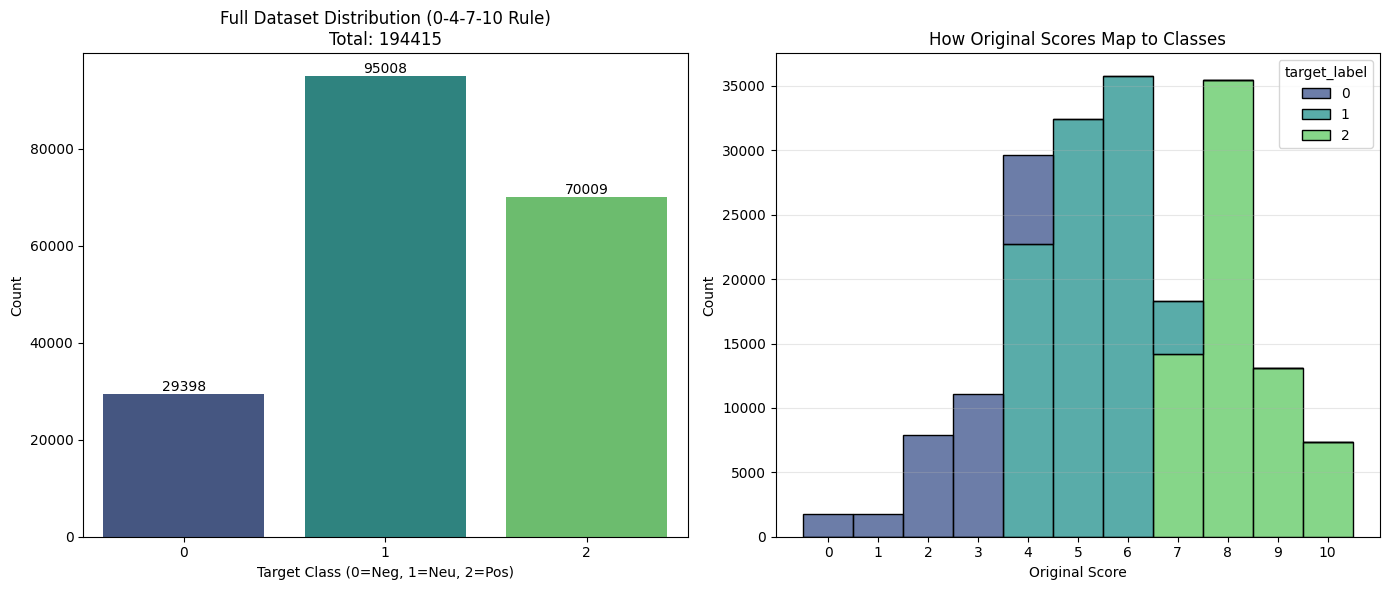

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# PART 2: CLEAN & SAVE FULL DATASET (0-4-7-10 Rule)
# ==========================================
print("\n" + "="*60)
print("PART 2: CLEANING & SAVING FULL DATASET (0-4-7-10 Rule)")
print("="*60)

SAVE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/Original_Rule_0_4_7_10_194k.csv'

# --- 1. PURITY FILTERING ---
print("Applying Strict Purity Filters...")

# Negative Bin (0 to <4): Must strictly be Original Negative (0)
df_neg_clean = df[
    (df['sentiment_3class'] == 'Negative') &
    (df['sentiment_label'] == 0)
]

# Positive Bin (7 to 10): Must strictly be Original Positive (1)
df_pos_clean = df[
    (df['sentiment_3class'] == 'Positive') &
    (df['sentiment_label'] == 1)
]

# Neutral Bin (4 to <7): Keep EVERYTHING (Mixed is good)
df_neu_clean = df[df['sentiment_3class'] == 'Neutral']

# Report
removed_neg = len(df[df['sentiment_3class'] == 'Negative']) - len(df_neg_clean)
removed_pos = len(df[df['sentiment_3class'] == 'Positive']) - len(df_pos_clean)
print(f"   > Removed {removed_neg} contaminated rows from Negative Class.")
print(f"   > Removed {removed_pos} contaminated rows from Positive Class.")

# --- 2. COMBINE (NO DOWNSAMPLING) ---
df_full_clean = pd.concat([df_neg_clean, df_neu_clean, df_pos_clean])
df_full_clean = df_full_clean.sample(frac=1, random_state=42).reset_index(drop=True)

# --- 3. CREATE INTEGER TARGET ---
# Map: Negative->0, Neutral->1, Positive->2
class_map = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
df_full_clean['target_label'] = df_full_clean['sentiment_3class'].map(class_map)

# --- 4. SAVE WITH ALL COLUMNS ---
cols_to_keep = [
    'title',                # Metadata
    'reviewText',           # Feature
    'originalScore',        # Feature
    'audienceScore',        # Feature
    'tomatoMeter',          # Feature
    'runtimeMinutes',       # Metadata
    'genre',                # Metadata
    'sentiment_label',      # Original Label
    'language_encoded',     # Metadata
    'director_encoded',     # Metadata
    'target_label'          # The New Class (0,1,2)
]

# Safety check
valid_cols = [c for c in cols_to_keep if c in df_full_clean.columns]
df_save = df_full_clean[valid_cols]

df_save.to_csv(SAVE_PATH, index=False)
print(f"\n✅ SUCCESS! Saved {len(df_save)} rows to:")
print(SAVE_PATH)

# ==========================================
# PART 3: SANITY CHECK & EDA
# ==========================================
print("\n" + "="*60)
print("FINAL SANITY CHECK REPORT (0-4-7-10 Rule)")
print("="*60)

# A. Composition Matrix
print("1. Class Composition (Check for Purity):")
cross_tab = pd.crosstab(df_save['target_label'], df_save['sentiment_label'])
cross_tab.columns = ['Orig Neg (0)', 'Orig Pos (1)']
cross_tab.index = ['Negative (0)', 'Neutral (1)', 'Positive (2)']
print(cross_tab)
print("-" * 60)

# B. Automated Verification
if cross_tab.loc['Negative (0)', 'Orig Pos (1)'] == 0:
    print("✅ PASS: Negative Class is 100% Pure.")
else:
    print("❌ FAIL: Negative Class is still contaminated.")

if cross_tab.loc['Positive (2)', 'Orig Neg (0)'] == 0:
    print("✅ PASS: Positive Class is 100% Pure.")
else:
    print("❌ FAIL: Positive Class is still contaminated.")

# C. Visualization
plt.figure(figsize=(14, 6))

# Graph 1: Total Counts
plt.subplot(1, 2, 1)
ax = sns.countplot(data=df_save, x='target_label', palette='viridis')
plt.title(f'Full Dataset Distribution (0-4-7-10 Rule)\nTotal: {len(df_save)}')
plt.xlabel('Target Class (0=Neg, 1=Neu, 2=Pos)')
plt.ylabel('Count')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

# Graph 2: Score Stack (To verify the cuts)
plt.subplot(1, 2, 2)
sns.histplot(data=df_save, x='originalScore', hue='target_label', multiple='stack',
             bins=11, palette='viridis', discrete=True)
plt.title('How Original Scores Map to Classes')
plt.xlabel('Original Score')
plt.xticks(range(11))
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()